In [1]:
%load_ext cython
import speckle_tracking as st
import pyrst as rst
from pyrst.bin import *
from pyrst import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from scipy.integrate import quad
from scipy.optimize import least_squares
from importlib import reload

pyximport.install(reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x7f90c84a9310>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['FFTW', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'ct_integrate', 'empty_aligned', 'init_newton', 'krig_data', 'lens', 'make_frames', 'make_reference', 'make_whitefield', 'mse_2d', 'np', 'subpixel_refinement_1d', 'subpixel_refinement_2d', 'total_mse', 'upm_newton_1d', 'upm_search']


In [3]:
def st_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5):
    """
    Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
    u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                            y_ps, z, df, verbose=False)
    I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

    es = []
    for i in range(n_iter):

        # calculate errors
        error_total = st.calc_error(I_n, M, W, dij_pix, I0, u, n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        es.append(error_total)

        # update pixel map
        u = st.update_pixel_map(I_n, M, W, I0, u, n0, m0, dij_pix,
                                search_window=[1, u_max], subpixel=True,
                                fill_bad_pix=True, integrate=False,
                                quadratic_refinement=True, verbose=False)[0]
        u_max = int(np.max(np.abs(u - np.indices(W.shape))))

        # make reference image
        I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

        # update translations
        dij_pix = st.update_translations(I_n, M, W, I0, u, n0, m0, dij_pix)[0]
    return {'u':u, 'I0':I0, 'errors':es, 'n0': n0, 'm0': m0}

def pixel_translations(basis, dij, df, z):
    dij_pix = (basis * dij[:, None]).sum(axis=-1)
    dij_pix /= (basis**2).sum(axis=-1) * df / z
    dij_pix -= dij_pix.mean(axis=0)
    return np.ascontiguousarray(dij_pix[:, 0]), np.ascontiguousarray(dij_pix[:, 1])

def str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5, l_scale=2.5):
    """
    Robust version of Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    I_n = I_n.astype(np.float64)
    W = W.astype(np.float64)
    u0 = np.indices(W.shape, dtype=np.float64)
    di, dj = pixel_translations(basis, dij, df, z)
    I0, n0, m0 = make_reference(I_n, W, u0, di, dj, l_scale, 0, 0)

    es = []
    for i in range(n_iter):

        # calculate errors
        es.append(total_mse(I_n, W, I0, u0, di - n0, dj - m0, l_scale))

        # update pixel map
        u = upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, u_max, l_scale)
        u_max = int(np.max(np.abs(u - u0)))
        u0 = u0 + gaussian_filter(u - u0, (0, 0, l_scale))

        # make reference image
        I0, n0, m0 = make_reference(I_n, W, u0, di, dj, l_scale, 0, 0)
        I0 = gaussian_filter(I0, (0, l_scale))
    return {'u':u0, 'I0':I0, 'errors':es, 'n0': n0, 'm0': m0}

In [4]:
def ab_model(pix, coeff):
    return coeff[0] + coeff[1] * (pix - coeff[3]) + coeff[2] * (pix - coeff[3])**2

def ab_errors(coeff, data, weights):
    return weights * (ab_model(data[:, 0], coeff) - data[:, 1])

def ph_model(theta, coeff):
    return coeff[0] + coeff[1] * (theta - coeff[4]) + \
           coeff[2] * (theta - coeff[4])**2 + coeff[3] * (theta - coeff[4])**3

def ph_errors(coeff, data):
    return ph_model(data[:, 0], coeff) - data[:, 1]

def phase_fit(u, x_ps, z, df, wl, u_var=1e-6, l_scale=5, max_order=4, roi=None):
    # calculate the phase
    if roi is None:
        roi = (0, u.shape[-1])
    u_pix = (u - np.indices((u.shape[1], u.shape[2])))[1, 0, roi[0]:roi[1]]
    ang = u_pix * x_ps / z
    phase = np.cumsum(ang) * x_ps * df / z * 2 * np.pi / wl
    pix = np.arange(u.shape[2])[roi[0]:roi[1]]
    x, theta = pix * x_ps, pix * x_ps / z

    data = np.stack((pix, gaussian_filter(u_pix, l_scale)), axis=-1)
    w = np.tanh(data[:, 1]**2 / u_var)

    # find a min/max argument
    u0 = gaussian_filter(u_pix, u_pix.shape[0] / 10)
    if np.median(np.gradient(np.gradient(u0))) > 0:
        idx = np.argmin(u0)
    else:
        idx = np.argmax(u0)

        
    # fit the model to the data
    bounds = ([-np.inf, -np.inf, -np.inf, 0],
              [np.inf, np.inf, np.inf, u_pix.shape[0]])
    fit = least_squares(ab_errors, np.array([0, 0, 0, pix[idx]]), args=(data, w),
                          xtol=1e-14, ftol=1e-14, bounds=bounds, loss='cauchy')
    ang_fit = np.array([fit.x[0], fit.x[1] / (x_ps / z),
                        fit.x[2] / (x_ps / z)**2, fit.x[3]]) * x_ps / z
    ph_fit = np.zeros(5)
    ph_fit[1:] = ang_fit; ph_fit[1:-1] *= 2 * np.pi / wl * df / (np.arange(3) + 1)
    ph_fit[0] = np.mean(phase - ph_model(theta, ph_fit))

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(fit.x, data, w)**2) / np.sum((w * (data[:, 1] - data[:, 1].mean()))**2)
    return {'pix': pix, 'theta': theta, 'u_pix': u_pix, 'angles': ang, 'phase': phase,
            'fit': fit, 'ang_fit': ang_fit, 'ph_fit': ph_fit, 'r_sq': r_sq}

# ST Simulation

In [13]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.1, bar_atn=0.18,
                           bulk_atn=0.2, p0 = 5e4, th_s=8e-5, n_frames=100,
                           offset=2.0, step_size=0.1, defocus=150, alpha=0.05,
                           ap_x=4, ap_y=2, x0=0.7, random_dev=0.8)

globals().update(**params.export_dict())

In [14]:
n_x = int(1.6 * ap_x / focus * defocus * fs_size * pix_size / wl / det_dist)
n_y = int(1.2 * ap_y * ss_size * pix_size / wl / det_dist)
x_arr = np.linspace(-0.8 * ap_x / focus * defocus, 0.8 * ap_x / focus * defocus, n_x)
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, n_y)
xx_arr = pix_size * np.arange(-fs_size // 2, fs_size // 2)
yy_arr = pix_size * np.arange(-ss_size // 2, ss_size // 2)
print(n_x, n_y)

482 905


In [18]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['FFTW', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'ct_integrate', 'empty_aligned', 'init_newton', 'krig_data', 'make_frames', 'make_reference', 'make_whitefield', 'mse_2d', 'np', 'subpixel_refinement_1d', 'subpixel_refinement_2d', 'total_mse', 'upm_newton_1d', 'upm_search']


In [17]:
%time wf0_x = lens(x_arr, wl, ap_x, focus, defocus, alpha, (x0 - 0.5) * ap_x)
%time wf0_x2 = dev.lens(x_arr, wl, ap_x, focus, defocus, alpha, (x0 - 0.5) * ap_x)

CPU times: user 14.1 ms, sys: 2.17 ms, total: 16.3 ms
Wall time: 1.97 ms
CPU times: user 14.9 ms, sys: 2.27 ms, total: 17.2 ms
Wall time: 2.17 ms


In [9]:
wf0_x = lens(x_arr, wl, ap_x, focus, defocus, alpha, (x0 - 0.5) * ap_x)
wf0_y = aperture(y_arr, focus + defocus, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, yy_arr, det_dist, wl)

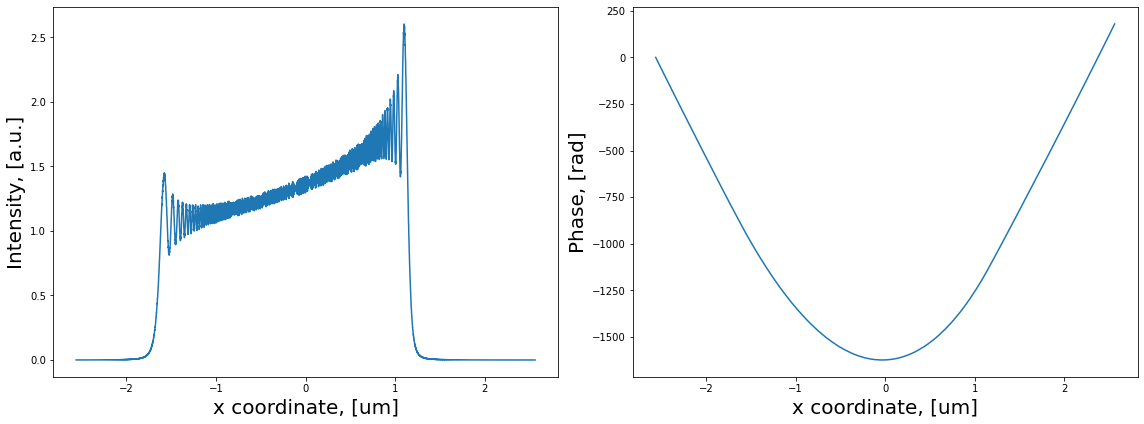

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_x.pdf')

In [11]:
fx_lim = np.array([-0.45 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / defocus
beam_span = np.clip(th_lim * defocus, x_arr[0], x_arr[-1])
wf0_roi = ((beam_span - x_arr[0]) // (x_arr[1] - x_arr[0])).astype(np.int)
xr_arr = x_arr[wf0_roi[0]:wf0_roi[1]]
wf0_ph = np.unwrap(np.angle(wf0_x))
wf0_ph_fc = np.polyfit(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], 3)
df_fit = np.pi / wl / wf0_ph_fc[1]
alpha_fit = wf0_ph_fc[0] * df_fit**3 * 1e-9
wf0_ph_fit = np.pi * xr_arr**2 / wl / df_fit + alpha_fit * 1e9 * (xr_arr / df_fit)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
wf0_ph_th = np.pi * xr_arr**2 / wl / defocus + alpha * 1e9 * (xr_arr / defocus)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
print(df_fit, alpha_fit)

132.18376963279678 0.04511842362160965


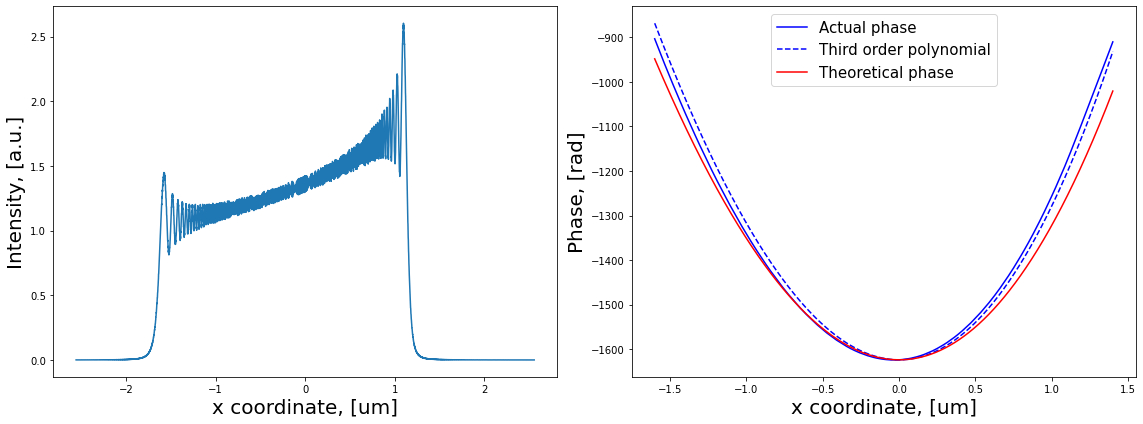

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], label='Actual phase', color='b')
axes[1].plot(xr_arr, wf0_ph_fit, color='b', label='Third order polynomial', linestyle='dashed')
axes[1].plot(xr_arr, wf0_ph_th, color='r', label='Theoretical phase')
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_phase_2.pdf')

In [13]:
bsteps = barcode_steps(x0=x_arr[0] + offset, x1=x_arr[-1] + n_frames * step_size - offset + 0.1,
                       br_dx=bar_size, rd=random_dev)
print(bsteps, x_arr[0] + offset, x_arr[-1] + n_frames * step_size - offset, offset)

[-0.80040482 -0.17685123  0.07120973  0.36500919  1.57998486  2.20299928
  3.26922174  4.13967054  4.96671574  5.8209946   6.25762639  6.53432182
  7.18773117  8.22013088  8.83135809  9.44403694] -0.56 10.56 2.0


In [14]:
bs_t = barcode_2d(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn, step_size, n_frames)
# bs_t = barcode_1d(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn)
wf1_x = fraunhofer_2d(wf0_x * bs_t, x_arr, xx_arr, det_dist, wl)

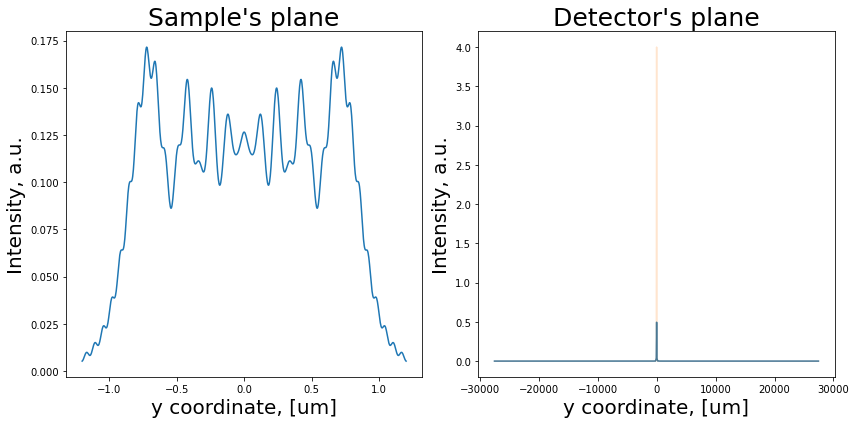

In [97]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(yy_arr, np.abs(wf1_y)**2)
axes[1].plot(yy_arr, (ap_y * np.sinc(np.pi * ap_y * yy_arr / wl / (det_dist + focus + defocus)))**2, alpha=0.2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

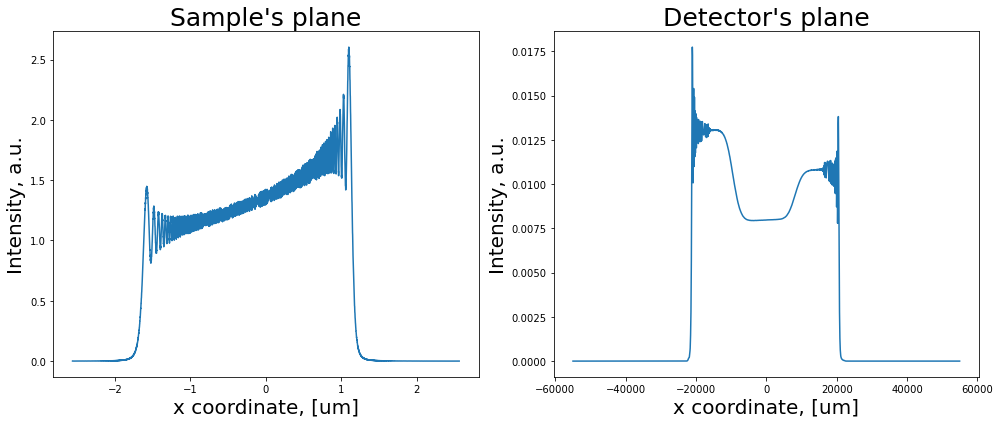

In [98]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(xx_arr, np.abs(wf1_x[0])**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

In [15]:
sigma = th_s * det_dist
sx_arr = pix_size * np.arange(-np.ceil(4 * sigma / pix_size), np.ceil(4 * sigma / pix_size) + 1)
s_arr = np.exp(-sx_arr**2 / 2 / sigma**2)
s_arr /= s_arr.sum()
print(sigma / pix_size)

2.909090909090909


In [16]:
det_c = 1 / wl**2 / (focus + defocus) / det_dist
i0 = p0 / ap_x / ap_y
data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)
beam_span = np.tan(th_lim) * (det_dist + defocus)
x_roi = np.clip((beam_span - xx_arr.min()) // pix_size, 0, fs_size).astype(np.int)
roi = (data.shape[1] // 2, data.shape[1] // 2 + 1, x_roi[0], x_roi[1])
ptych = data[:, :, roi[2]:roi[3]].sum(axis=1)
mask = np.ones((data.shape[1], data.shape[2]), dtype=np.uint8)
whitefield = make_whitefield(data, mask)
print(data.shape, np.mean(ptych[..., 20:-20]), np.std(ptych[..., 20:-20]),
      np.std(ptych[..., 20:-20]) / np.sqrt(np.mean(ptych[..., 20:-20])))

(100, 1, 2000) 46.3228488372093 6.235106535740471 0.9161070982358616


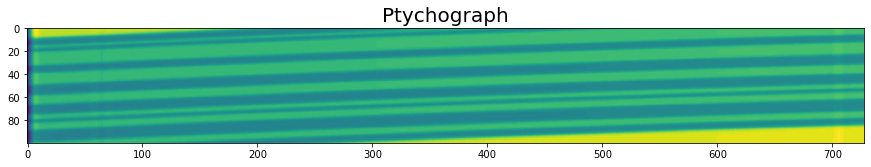

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(ptych)
ax.set_title('Ptychograph', fontsize=20)
plt.show()

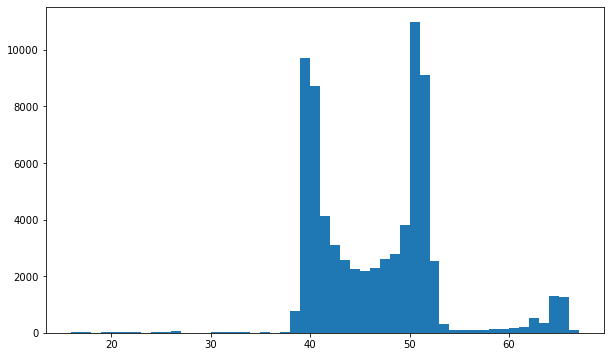

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ptych.ravel(), min(int(ptych.max() - ptych.min()), 100))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [11]:
x_arr = np.linspace(-0.75, 0.75, 512)[:, None]
y_arr = np.linspace(-1.5, 1.5, 512)[None, :]
z_arr = 0.3 * x_arr + np.exp(-6 * x_arr**2 - 6 * (y_arr - 0.7)**2) - \
        np.exp(-3 * x_arr**2 - 6 * (y_arr + 0.7)**2)
z_pad = np.pad(z_arr, ((0, 0), (z_arr.shape[1], 0)), mode='symmetric')
z_pad = np.pad(z_pad, ((z_arr.shape[0], 0), (0, 0)), mode='symmetric')
sx_arr = np.gradient(z_arr, axis=0)
sy_arr = np.gradient(z_arr, axis=1)

In [15]:
sx_arr = ((u - u0)[0] - (u - u0)[0].mean())
sy_arr = ((u - u0)[1] - (u - u0)[1].mean())

%time phase_st = st.integrate(sx_arr, sy_arr, np.ones(sx_arr.shape), 100, [1, 1])[0]
%time phase_cti = dev.ct_integrate(sx_arr, sy_arr)
print(phase_st.min(), phase_st.max())
print(phase_cti.min(), phase_cti.max())

cgls err: 5.66e+36: 100%|██████████| 100/100 [00:01<00:00, 85.00it/s]


CPU times: user 1.18 s, sys: 48.5 ms, total: 1.23 s
Wall time: 1.19 s
CPU times: user 47.5 ms, sys: 3.24 ms, total: 50.8 ms
Wall time: 49.7 ms
-517.5596760389825 93.92172581870537
-446.13297404009177 185.48710877371087


In [16]:
error_cti = np.mean((np.gradient(phase_cti, axis=0) - sx_arr)**2 + (np.gradient(phase_cti, axis=1) - sy_arr)**2)
error_st = np.mean((np.gradient(phase_st, axis=0) - sx_arr)**2 + (np.gradient(phase_st, axis=1) - sy_arr)**2)
print(error_cti, error_st)

0.9005542339373555 1.3285948122947222


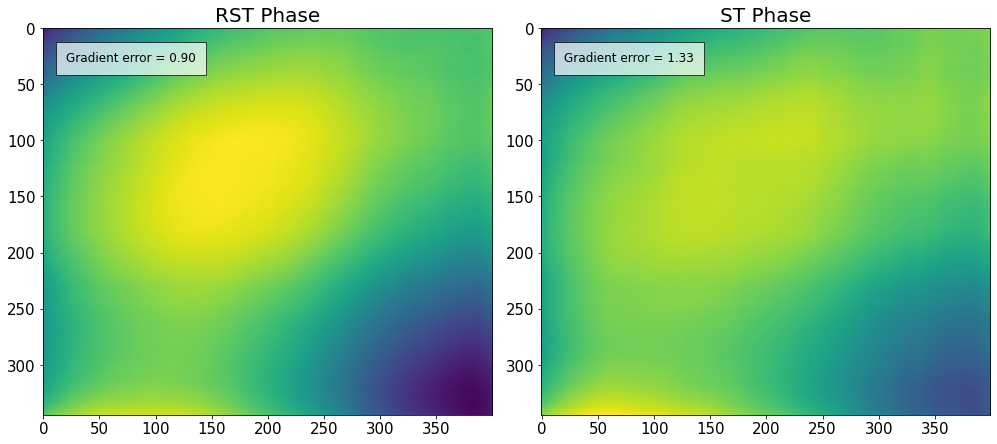

In [49]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(phase_cti)
axes[0].text(20, 30, 'Gradient error = {:.2f}'.format(error_cti), fontsize=12,
             bbox={'facecolor': 'white', 'pad': 10, 'alpha': 0.7})
axes[0].set_title('RST Phase', fontsize=20)
axes[1].imshow(phase_st)
axes[1].text(20, 30, 'Gradient error = {:.2f}'.format(error_st), fontsize=12,
             bbox={'facecolor': 'white', 'pad': 10, 'alpha': 0.7})
axes[1].set_title('ST Phase', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/rst_phase.pdf')

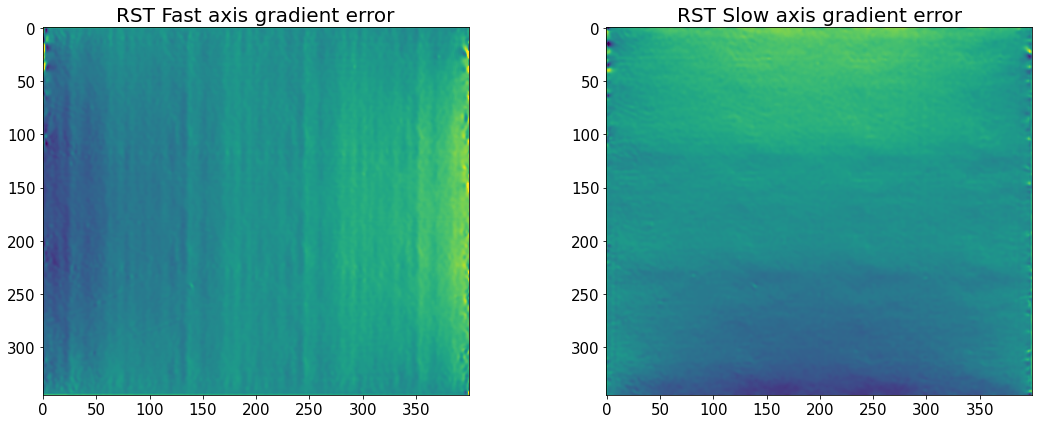

In [67]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((np.gradient(phase_cti, axis=0) - sx_arr), vmin=-3, vmax=3)
axes[0].set_title('RST Fast axis gradient error', fontsize=20)
axes[1].imshow((np.gradient(phase_cti, axis=1) - sy_arr), vmin=-3, vmax=3)
axes[1].set_title('RST Slow axis gradient error', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
# plt.show()
plt.savefig('figures/dev_angles_error_rst.pdf')

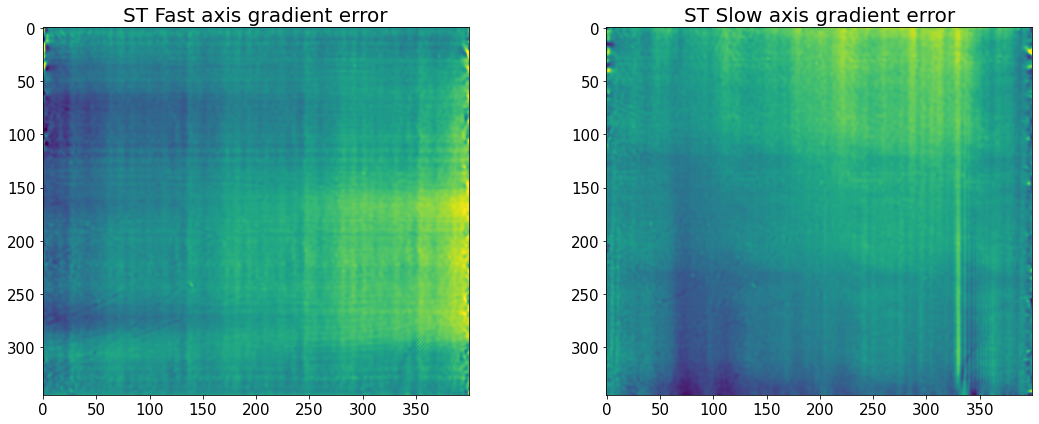

In [70]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((np.gradient(phase_st, axis=0) - sx_arr), vmin=-3, vmax=3)
axes[0].set_title('ST Fast axis gradient error', fontsize=20)
axes[1].imshow((np.gradient(phase_st, axis=1) - sy_arr), vmin=-3, vmax=3)
axes[1].set_title('ST Slow axis gradient error', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.show()
plt.savefig('figures/dev_angles_error_st.pdf')

In [5]:
dir_path = 'results/test_ideal'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data0 = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
rst_obj0 = rst_data0.get_st()
rst_res0, errors = rst_obj0.iter_update([0, 150], ls_pm=5., ls_ri=10, verbose=True, n_iter=10)

Iteration No. 0: Total MSE = 0.128
Iteration No. 1: Total MSE = 0.055
Iteration No. 2: Total MSE = 0.030
Iteration No. 3: Total MSE = 0.029


In [5]:
print(type(rst.INIParser.export_ini))

<class 'method'>


In [6]:
dir_path = 'results/test'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
rst_data = rst_data.make_whitefield()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update([0, 150], ls_pm=3., ls_ri=10, verbose=True, n_iter=10)

rst_data.update_phase(rst_res)
fit_res = rst_data.fit_phase()
fit_res['ph_fit']

Iteration No. 0: Total MSE = 0.150
Iteration No. 1: Total MSE = 0.077
Iteration No. 2: Total MSE = 0.052
Iteration No. 3: Total MSE = 0.050


array([-5.18966915e+07, -8.63981712e+05,  3.42460579e+03,  2.98555644e+01,
        1.19790100e-02])

In [7]:
fit_res

{'fit': array([-3.31169263e-04, -1.33656765e-01,  9.63239523e+00,  4.35600364e+02]),
 'ang_fit': array([-1.20425186e+01, -1.33656765e-01,  2.64890869e-04,  1.19790100e-02]),
 'ph_fit': array([-5.18966915e+07, -8.63981712e+05,  3.42460579e+03,  2.98555644e+01,
         1.19790100e-02]),
 'error': array([4.75364024e-06, 3.28641055e+04, 6.63182014e+06, 4.96182908e+07]),
 'r_sq': 0.9900782345787699}

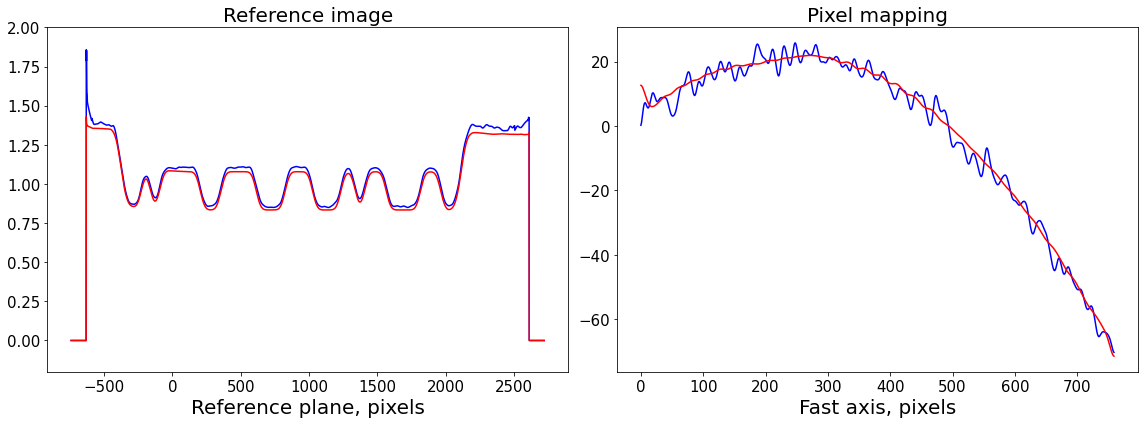

In [30]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(np.arange(rst_res.reference_image.shape[1]) - rst_res.m0,
             rst_res.reference_image[0], 'b')
axes[0].plot(np.arange(rst_res0.reference_image.shape[1]) - rst_res0.m0,
             rst_res0.reference_image[0], 'r')
axes[0].set_ylim(-0.2, 2)
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=20)
axes[1].plot((rst_res.pixel_map - rst_obj.pixel_map)[1, 0], 'b')
axes[1].plot((rst_res0.pixel_map - rst_obj0.pixel_map)[1, 0], 'r')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [25]:
loader = rst.loader()
rst_data = loader.load('results/exp/diatom.cxi', defocus=2.23e-3,
                       roi=(75, 420, 55, 455), good_frames=np.arange(1, 121))
rst_data = rst_data.make_mask(method='perc-bad')

rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update([15, 15], ls_pm=1.5, ls_ri=0.7, verbose=True, n_iter=5)

Iteration No. 0: Total MSE = 0.798
Iteration No. 1: Total MSE = 0.711
Iteration No. 2: Total MSE = 0.256
Iteration No. 3: Total MSE = 0.205
Iteration No. 4: Total MSE = 0.209


In [42]:
import logging

rst.loader()

In [23]:
loader = rst.loader()
rst_data = loader.load('results/exp/MLL_00223.cxi', defocus_fs=2.9163e-4, defocus_ss=3.9318e-4,
                       roi=(35, 445, 265, 695))
rst_data = rst_data.make_mask(method='perc-bad')
rst_data = rst_data.update_defocus((2.9318e-4, 2.9163e-4))

rst_obj = rst_data.get_st()
# rst_res, errors = rst_obj.iter_update([15, 15], ls_pm=1.5, ls_ri=0.7, verbose=True, n_iter=5)

CPU times: user 52.2 s, sys: 254 ms, total: 52.5 s
Wall time: 5.12 s


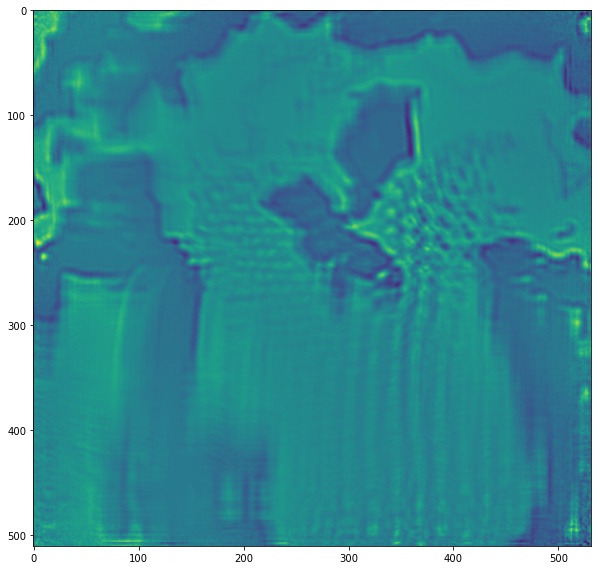

In [24]:
%time rst_obj = rst_obj.update_reference(ls_ri=0.7)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rst_obj.reference_image)
plt.show()

In [9]:
W = rst_res.whitefield
I_n = rst_res.data
I0 = rst_res.reference_image
n0 = rst_res.n0
m0 = rst_res.m0
u0 = rst_obj.pixel_map
u = rst_res.pixel_map
di = rst_res.dss_pix
dj = rst_res.dfs_pix

In [21]:
I_n.shape

(441, 410, 430)

In [20]:
W = rst_data.get('whitefield')
I_n = rst_data.get('data')
u0 = rst_data.get('pixel_map')
basis = rst_data.get('basis_vectors')
z = rst_data.get('distance')
x_ps = rst_data.get('x_pixel_size')
y_ps = rst_data.get('y_pixel_size')
wl = rst_data.get('wavelength')
dij = rst_data.get('translations')
df_ss = rst_data.get('defocus_ss')
df_fs = rst_data.get('defocus_fs')

M = ((I_n - np.median(I_n))**2 < np.percentile((I_n - np.median(I_n))**2, 99.99)).all(axis=0)
W *= M; I_n *= M

sw_max = 10
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df_fs, df_ss, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
# %time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
#                                  u0, n0_st, m0_st, dij_pix, subpixel=True, \
#                                  search_window=[2 * sw_max, 2 * sw_max], \
#                                  fill_bad_pix=True, integrate=False, \
#                                  quadratic_refinement=True, verbose=False)[0]

CPU times: user 5.05 s, sys: 305 ms, total: 5.36 s
Wall time: 5.26 s


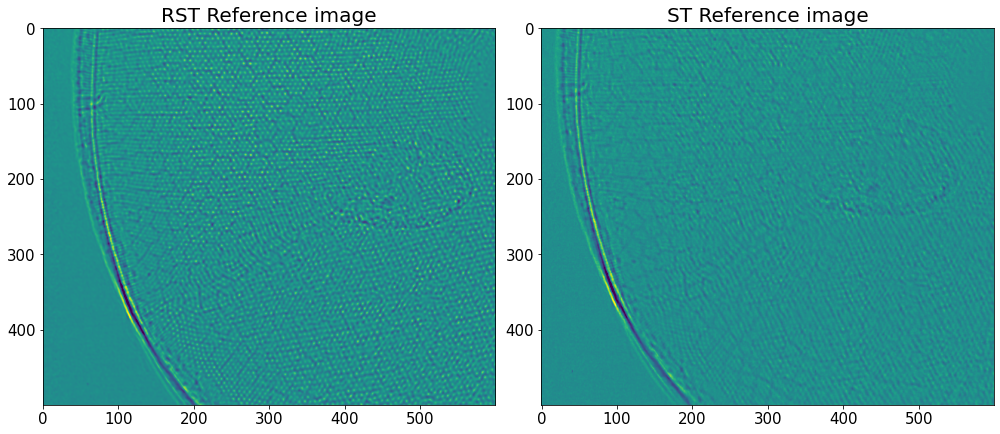

In [64]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(I0[700:1200, 100:700], vmin=0.7, vmax=1.3)
axes[0].set_title('RST Reference image', fontsize=20)
axes[1].imshow(I0_st[700:1200, 100:700], vmin=0.7, vmax=1.3)
axes[1].set_title('ST Reference image', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/reference_image_2d.pdf')

In [17]:
sw_max = 15
j, k = 116, 98
ls_ri = 0.7
ls_pm = 1.5

I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj, ls_ri, 0, 0)
u = upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, sw_max, sw_max, ls_pm)

In [34]:
ls_ri = 0.7
ls_pm = 1.5
c_ri, c_pm = 0.5, 0.5
u_res = u0.copy()
u_res += c_pm * gaussian_filter(u - u0, (0, ls_pm, ls_pm))
I0_res = I0.copy()
ss_roi = np.clip([n0 - n0_rst, I0_rst.shape[0] + n0 - n0_rst], 0, I0_res.shape[0]) - n0
fs_roi = np.clip([m0 - m0_rst, I0_rst.shape[1] + m0 - m0_rst], 0, I0_res.shape[1]) - m0
ss_s0, fs_s0 = slice(*(ss_roi + n0)), slice(*(fs_roi + m0))
ss_s1, fs_s1 = slice(*(ss_roi + n0_rst)), slice(*(fs_roi + m0_rst))
I0_res[ss_s0, fs_s0] += c_ri * gaussian_filter(I0_rst[ss_s1, fs_s1] - I0_res[ss_s0, fs_s0],
                                               (ls_ri, ls_ri))

In [35]:
print(dev.total_mse(I_n, W, I0, u0, di - n0, dj - m0, ls_ri))
print(dev.total_mse(I_n, W, I0_rst, u, di - n0_rst, dj - m0_rst, ls_ri))
print(dev.total_mse(I_n, W, I0_res, u_res, di - n0, dj - m0, ls_ri))

0.2443718430318201
0.2264406241981858
0.24601415472295715


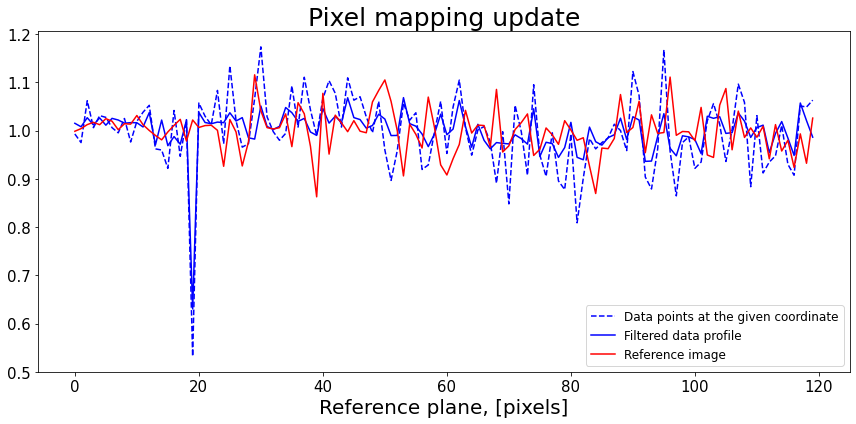

In [59]:
ffs = u0[1] - dj[:, None, None] + m0
sfs = u0[0] - di[:, None, None] + n0

%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot((I_n[:, j, k] / W[j, k]).ravel(), 'b--',
        label='Data points at the given coordinate')
ax.plot(dev.krig_data(I_n, W, u0, j, k, 1.4)[:-1], 'b',
        label='Filtered data profile')
ax.plot(I0_rst[sfs[:, j, k].astype(int), ffs[:, j, k].astype(int)].ravel(), 'r',
        label='Reference image')
ax.set_xlabel('Reference plane, [pixels]', fontsize=20)
ax.set_title('Pixel mapping update', fontsize=25)
ax.legend(fontsize=12)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_update.pdf')

In [16]:
mse, mse_var = dev.mse_2d(I_n, W, I0_rst, u0, di - n0, dj - m0, sw_max, sw_max, ls_pm)
l1 = dev.init_stars(I_n, W, I0_rst, u0, di - n0, dj - m0, sw_max, sw_max, ls_pm)
mse.shape, mse_var.shape, l1.shape

((350, 410, 40, 40), (350, 410, 40, 40), (350, 410))

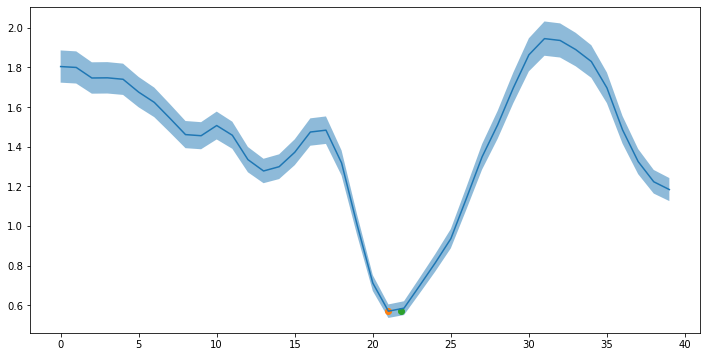

In [26]:
j, k = 110, 250
ss_min = int(u_np[0, j, k] + sw_max)
fs_min = int(u_np[1, j, k] + sw_max)
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(np.arange(2 * sw_max), mse[j, k, :, fs_min] + np.sqrt(mse_var[j, k, :, fs_min]),
                mse[j, k, :, fs_min] - np.sqrt(mse_var[j, k, :, fs_min]), alpha=0.5)
ax.plot(mse[j, k, :, fs_min])
ax.scatter(ss_min, mse[j, k, ss_min, fs_min])
ax.scatter(ss_min + du_s[j, k], mse[j, k, ss_min, fs_min])
plt.show()

In [156]:
sw_max = 20
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
ls_ri = 0.7
ls_pm = 1.5

%time I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj, \
                                              ls_ri, wfs=0)
%time u_rst = dev.upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, \
                             sw_max, sw_max, ls_pm)

CPU times: user 21.6 s, sys: 63.2 ms, total: 21.7 s
Wall time: 1.91 s
CPU times: user 13min 22s, sys: 838 ms, total: 13min 23s
Wall time: 1min 9s


In [157]:
sw_max = 10
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
%time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
                                 u0, n0_st, m0_st, dij_pix, subpixel=True, \
                                 search_window=[2 * sw_max, 2 * sw_max], \
                                 fill_bad_pix=True, integrate=False, \
                                 quadratic_refinement=True, verbose=False)[0]

CPU times: user 3.56 s, sys: 509 ms, total: 4.07 s
Wall time: 2.25 s
-10 10
-10 10


updating pixel map: 6.96e-01: 100%|██████████| 1435/1435 [04:18<00:00,  5.55it/s]


quadratic_refinement: True
CPU times: user 9min 42s, sys: 5min 57s, total: 15min 40s
Wall time: 4min 21s


In [158]:
print(dev.total_mse(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, 1.5))
print(dev.total_mse(I_n, W, I0_rst, u_rst, di - n0_rst, dj - m0_rst, 1.5))

0.8383653921785708
0.39629493914876224


In [159]:
print(dev.total_mse(I_n, W, I0_rst, u0, di - n0_st, dj - m0_st, 1.5))
print(dev.total_mse(I_n, W, I0_rst, u_st, di - n0_st, dj - m0_st, 1.5))

0.7737409180275016
0.4036527191392844


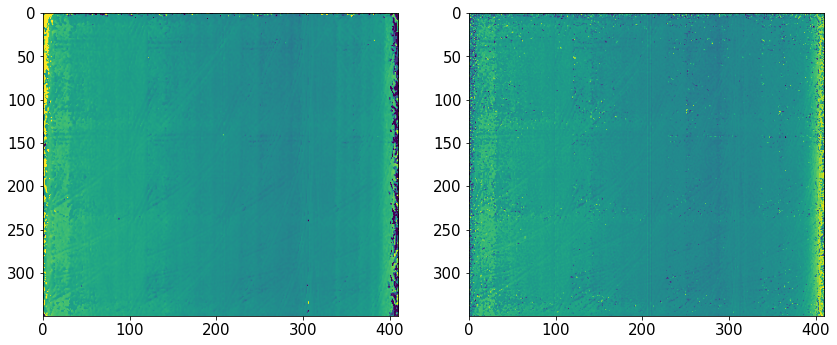

In [160]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow((u_rst - u0)[1], vmin=-10, vmax=10)
axes[1].imshow((u_st - u0)[1], vmin=-10, vmax=10)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.show()

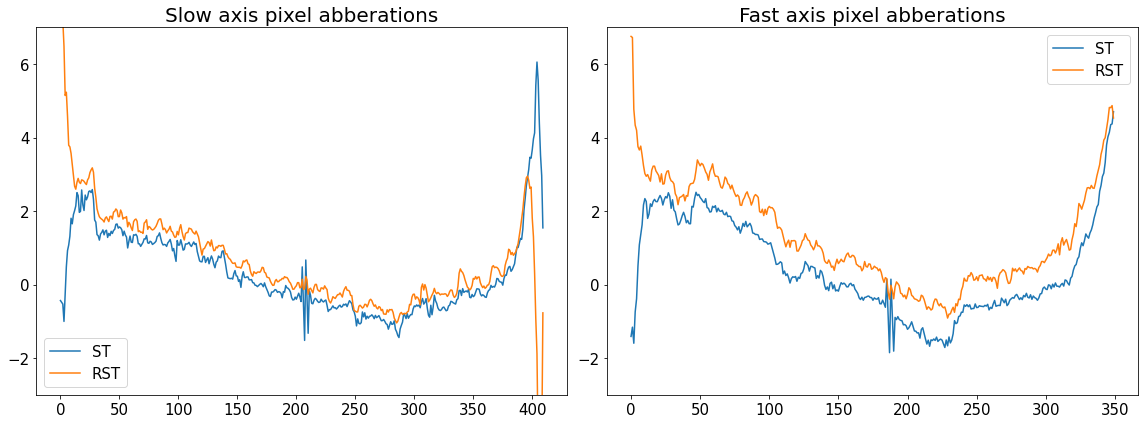

In [161]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((u_st - u0)[1].mean(axis=0), label='ST')
axes[0].plot((u_rst - u0)[1].mean(axis=0), label='RST')
axes[0].set_title('Slow axis pixel abberations', fontsize=20)
axes[1].plot((u_st - u0)[0].mean(axis=1), label='ST')
axes[1].plot((u_rst - u0)[0].mean(axis=1), label='RST')
axes[1].set_title('Fast axis pixel abberations', fontsize=20)
for ax in axes:
    ax.set_ylim(-3, 7)
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/pm_2d.pdf')

# Simulation results

In [31]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

di, dj = pixel_translations(basis, dij, df, z)
I_n, W = I_n.astype(np.float64), W.astype(np.float64)
I_n.shape[-1], (dij[0] - dij[1]), basis[0]

(728,
 array([1.e-07, 0.e+00, 0.e+00]),
 array([[ 0.0e+00, -5.5e-05,  0.0e+00],
        [ 5.5e-05,  0.0e+00,  0.0e+00]]))

In [67]:
df_arr = np.linspace(0.7, 1.3) * df
defocus = np.array([defocus_ss, defocus_fs]) * np.ones((df_arr.size, 2))
defocus[:, (1, )] = df_arr[:, None]
list(1)

TypeError: 'int' object is not iterable

In [41]:
dij_pix = (dij[:, None] * basis).sum(axis=-1)
dij_pix /= (basis**2).sum(axis=-1) * np.array([defocus_ss, defocus_fs]) / z

In [111]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, 20., 0, 0, return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

7.554180242512434 30.02999999999999 728
3.1681538342778946e-06


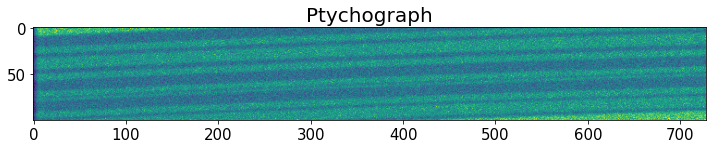

In [112]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [66]:
params = st_sim.parameters()

fx = params.ap_x / 2 / params.focus
z_bar = params.defocus * params.det_dist / (params.defocus + params.det_dist)
th_max = abs(params.wl / 2 / np.pi * params.alpha * 3e9 * fx**2 / (params.defocus + z_bar))
sw_max = max(int(2 * th_max / params.pix_size * params.det_dist), 10)
print(sw_max, th_max)

28 0.00038678518249739865


In [71]:
#---------------------------
# Intialise
#---------------------------
u0, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                         y_ps, z, df, verbose=False)
I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)
u = st.update_pixel_map(I_n.astype(np.float32), M, W, I0, u0, n0, m0, dij_pix,
                        search_window=[1, 100], subpixel=True,
                        fill_bad_pix=True, integrate=False,
                        quadratic_refinement=True, verbose=False)[0]

updating pixel map: 6.64e-01:  50%|█████     | 4/8 [00:00<00:00, 34.59it/s]

0 1
-50 50


updating pixel map: 6.48e-01: 100%|██████████| 8/8 [00:00<00:00, 34.77it/s]


quadratic_refinement: True


In [73]:
st_res = st_update(I_n.astype(np.float32), W.astype(np.float32), dij, basis, x_ps, y_ps, z, df)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl)

updating pixel map: 6.64e-01:  50%|█████     | 4/8 [00:00<00:00, 30.34it/s]

0 1
-50 50


updating object map and translations: 6.40e+01:   2%|▏         | 2/100 [00:00<00:05, 16.89it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.22e-01:  75%|███████▌  | 6/8 [00:00<00:00, 54.11it/s]

(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
0 1
-26 26


building object map:   0%|          | 0/100 [00:00<?, ?it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.10e-01: 100%|██████████| 8/8 [00:00<00:00, 41.47it/s]

0 1
-37 37
quadratic_refinement: True



updating pixel map: 6.06e-01:   0%|          | 0/8 [00:00<?, ?it/s]

(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
0 1
-39 39


calculating errors:   0%|          | 0/100 [00:00<?, ?it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.04e-01:  50%|█████     | 4/8 [00:00<00:00, 35.51it/s]

0 1
-39 39


updating object map and translations: 6.21e+01:   0%|          | 0/100 [00:00<?, ?it/s]


quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


In [138]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, l_scale=7.5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var=20)

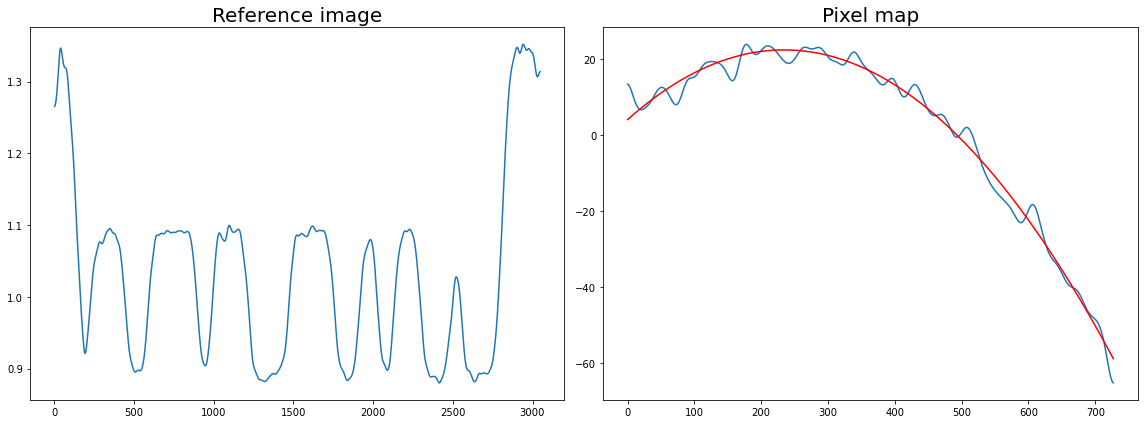

In [139]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

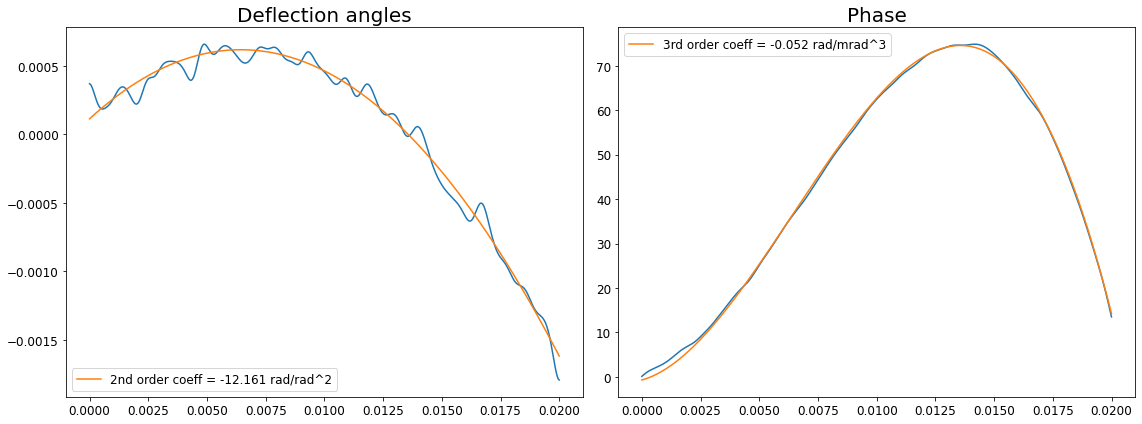

In [140]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(phr_res['theta'], phr_res['phase'])
axes[1].plot(phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_fits_5it.pdf')

# Experiment results

In [680]:
loader = rst.loader()
rst_data = loader.load('results/exp/diatom.cxi', defocus=2.23e-3,
                       roi=(70, 420, 50, 460),
                       good_frames=np.arange(1, 121))
rst_data = rst_data.make_mask(method='eiger-bad')

In [681]:
I_n = rst_data.get('data')
basis = rst_data.get('basis_vectors')
z = rst_data.get('distance')
x_ps = rst_data.get('x_pixel_size')
y_ps = rst_data.get('y_pixel_size')
wl = rst_data.get('wavelength')
dij = rst_data.get('translations')
W = rst_data.get('whitefield')
df = rst_data.get('defocus')

M = ((I_n - np.median(I_n))**2 < np.percentile((I_n - np.median(I_n))**2, 99.99)).all(axis=0)
W *= M; I_n *= M

In [663]:
sw_max = 20
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
ls_ri = 0.7
ls_pm = 1.5

%time I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj,
                                              ls_ri, wfs=0)
%time u_rst = upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst,
                         sw_max, sw_max, ls_pm)

CPU times: user 18.6 s, sys: 43.6 ms, total: 18.6 s
Wall time: 1.67 s
CPU times: user 10min 43s, sys: 755 ms, total: 10min 44s
Wall time: 56.2 s


In [664]:
sw_max = 20
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
%time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
                                 u0, n0_st, m0_st, dij_pix, \
                                 search_window=[2 * sw_max, 2 * sw_max],
                                 subpixel=True, \
                                 fill_bad_pix=True, integrate=False, \
                                 quadratic_refinement=True, verbose=False)[0]

CPU times: user 3.53 s, sys: 391 ms, total: 3.92 s
Wall time: 2.13 s
-10 10
-10 10


updating pixel map: 6.96e-01: 100%|██████████| 1435/1435 [03:42<00:00,  6.44it/s]


quadratic_refinement: True
CPU times: user 8min 50s, sys: 3min 50s, total: 12min 41s
Wall time: 3min 48s


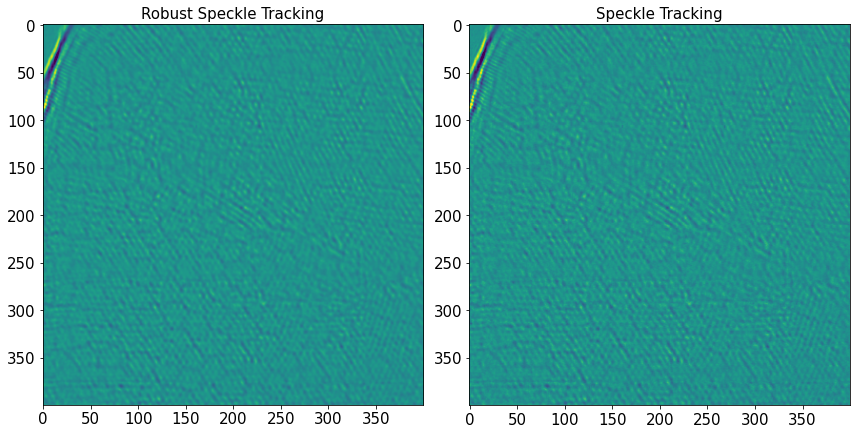

In [707]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(I0_rst[400:800, 200:600], vmin=0.7, vmax=1.3)
axes[0].set_title('Robust Speckle Tracking', fontsize=15)
axes[1].imshow(I0_st[400:800, 200:600], vmin=0.7, vmax=1.3)
axes[1].set_title('Speckle Tracking', fontsize=15)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.show()
# plt.savefig('figures/ri_2d.pdf')

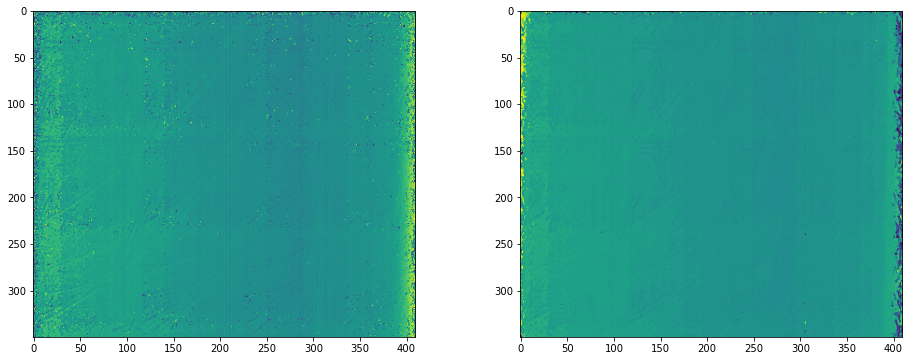

In [666]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((u_st - u0)[1])
axes[1].imshow((u_rst - u0)[1])
plt.show()

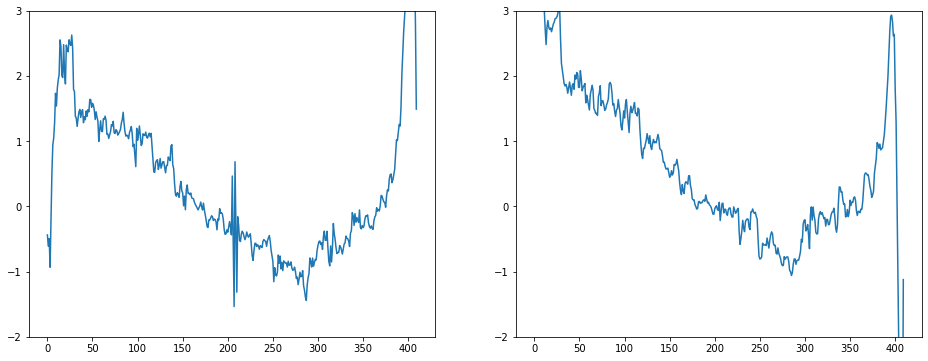

In [101]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((u_st - u0)[1].mean(axis=0))
axes[1].plot((u_rst - u0)[1].mean(axis=0))
for ax in axes:
    ax.set_ylim(-2, 3)
plt.show()

In [163]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2008

loader = rst.loader()
rst_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num], defocus=1.0e-4)
rst_data = rst_data.update_defocus()
rst_data = rst_data.make_whitefield()
rst_data = rst_data.make_pixel_map()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(300, ls_ri=15, ls_pm=5, verbose=True, n_iter=10, method='search')
rst_res.update_data()

Iteration No. 0: Total MSE = 0.179
Iteration No. 1: Total MSE = 0.088
Iteration No. 2: Total MSE = 0.084
Iteration No. 3: Total MSE = 0.084


In [167]:
ab_fit = rst_data.get_ab_fit()
fit_data = ab_fit.fit_pixel_ab(np.arange(rst_res.pixel_map.shape[-1]),
                               (rst_res.pixel_map - rst_obj.pixel_map)[1, 0],
                               max_order=3)

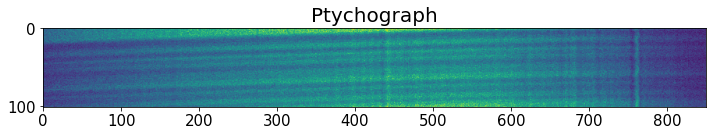

In [152]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(st_data.get('data')[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

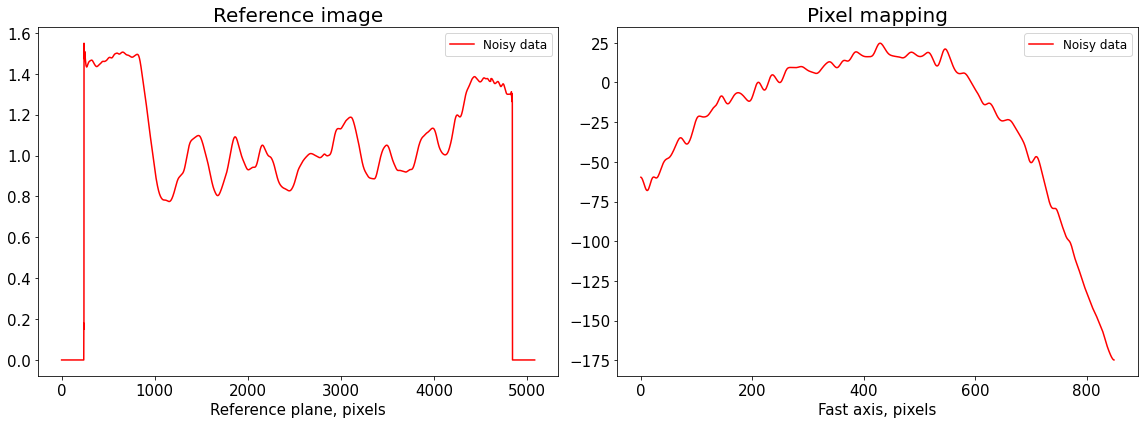

In [168]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(rst_res.reference_image[0], 'r', label='Noisy data')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((rst_res.pixel_map - rst_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

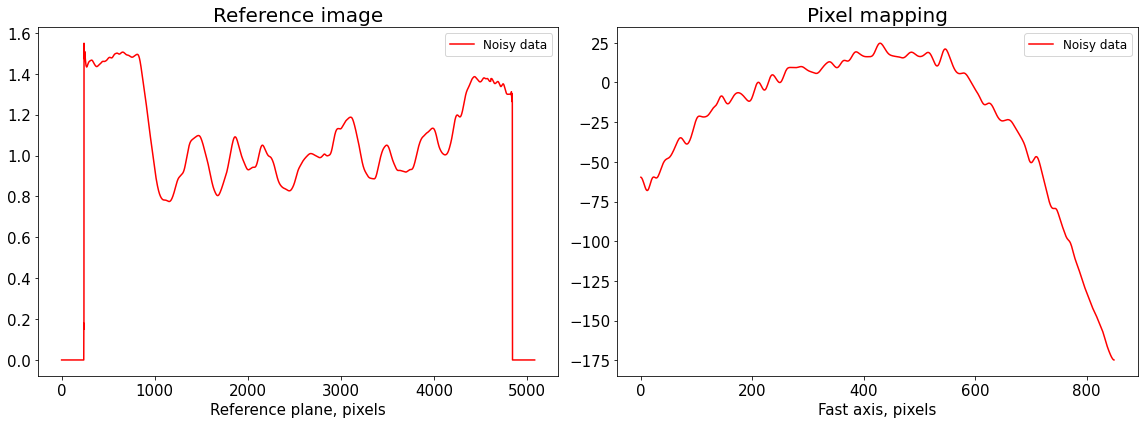

In [153]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], 'r', label='Noisy data')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

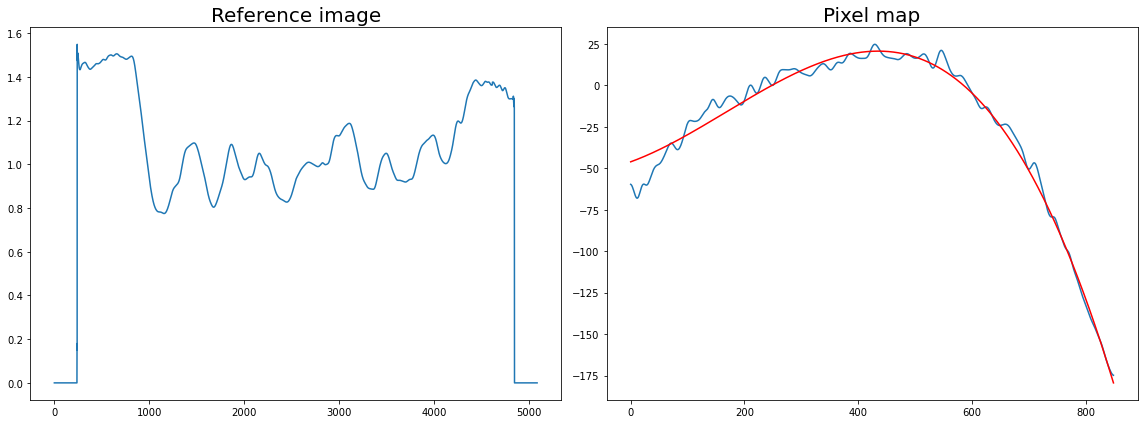

In [155]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(fit_data['pixels'], fit_data['pixel_ab'])
axes[1].plot(fit_data['pixels'], ab_fit.model(fit_data['fit'], fit_data['pixels']), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_2008.pdf')

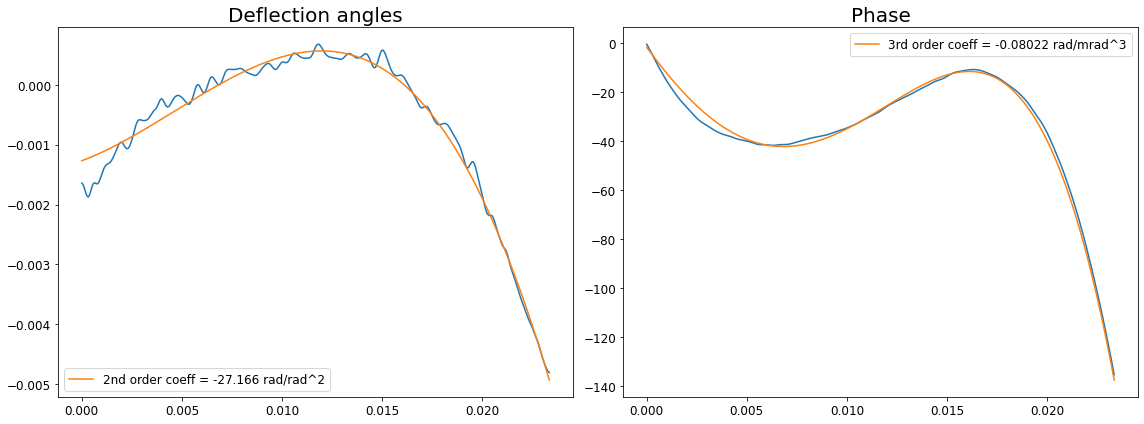

In [156]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('deviation_angles')[1, 0])
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, ab_fit.angles_model(fit_data['fit'], fit_data['pixels']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ab_fit.to_ang_fit(fit_data['fit'])[-4]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('phase')[0])
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap,
             ab_fit.phase_model(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0]),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(
                 ab_fit.to_ph_fit(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0])[-5] * 1e-9
             ))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_2008.pdf')

In [19]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 2008

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]].sum(axis=1)[:, None]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 1e-4
I_n = I_n.astype(np.float64)
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield_st(I_n, M)
(dij[1] - dij[0]), I_n.shape[-1], np.mean(I_n), basis[0]

(array([0.0e+00, 9.6e-08, 0.0e+00]),
 850,
 72.90818870122307,
 array([[-5.5e-05,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -5.5e-05,  0.0e+00]]))

In [20]:
I_n.shape

(101, 1, 850)

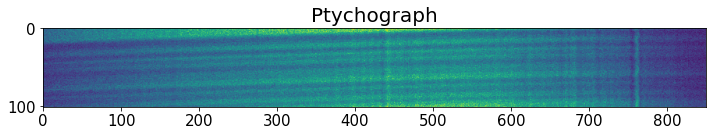

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [73]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, ls=20., return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

10.151162106893096 24.348958333599075 850
1.2507496085642653e-06


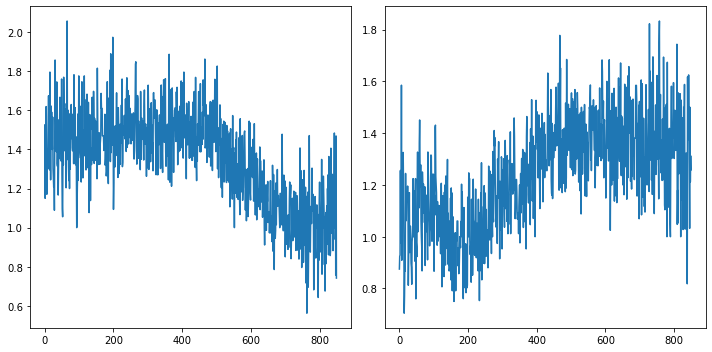

In [74]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_n[1, 0] / W[0] )
axes[1].plot(I_n[-1, 0] / W[0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [75]:
#---------------------------
# Intialise
#---------------------------
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
l_scale = 5.5
sw_max = 300

I0, n0, m0 = dev.make_reference(I_n, W, u0, di, dj, ls=l_scale, wfs=0)
I0_avg = dev.make_reference(I_n, W, u0, di, dj, ls=30, wfs=0)[0]
u = dev.upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, sw_max, l_scale)
# u = dev.upm_newton_1d(I_n, W, I0, u0, di, dj, sw_max, l_scale)
u = u0 + gaussian_filter(u - u0, (0, 0, l_scale))
print(I0.shape)

(1, 4484)


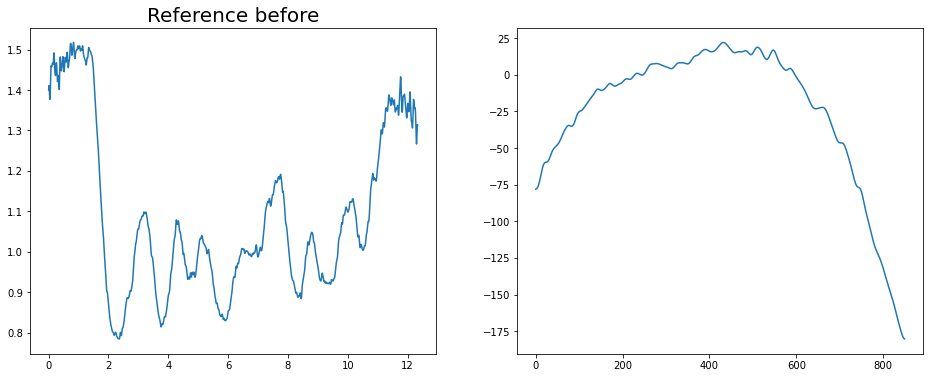

In [76]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0[0])
axes[0].set_title('Reference before', fontsize=20)
axes[1].plot((u - u0)[1, 0])
plt.show()
# plt.savefig('figures/reference_1595.pdf')

In [176]:
st_res = st_update(I_n.astype(np.float32), W, dij, basis, x_ps, y_ps, z, df, u_max=300)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl, u_var)

updating object map and translations: 4.73e+01:   0%|          | 0/100 [00:00<?, ?it/s]


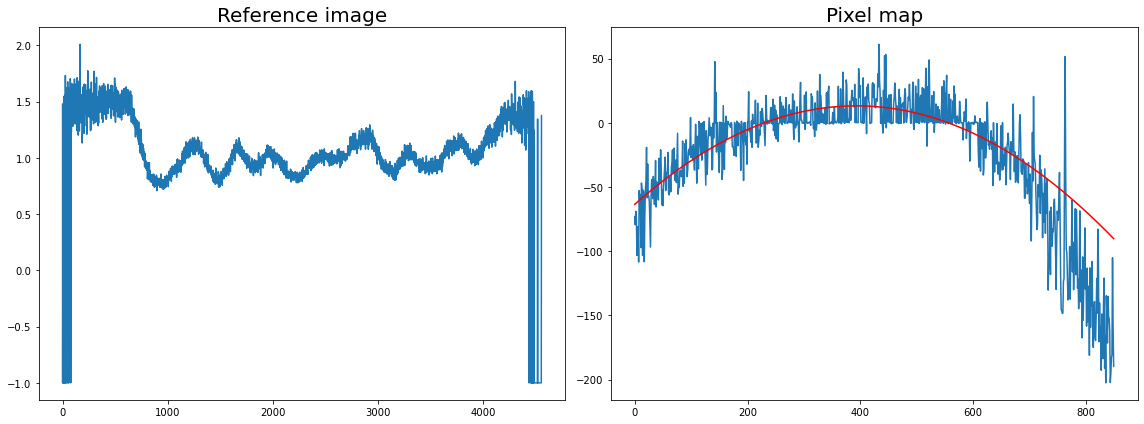

In [159]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_andrew_1727.pdf')

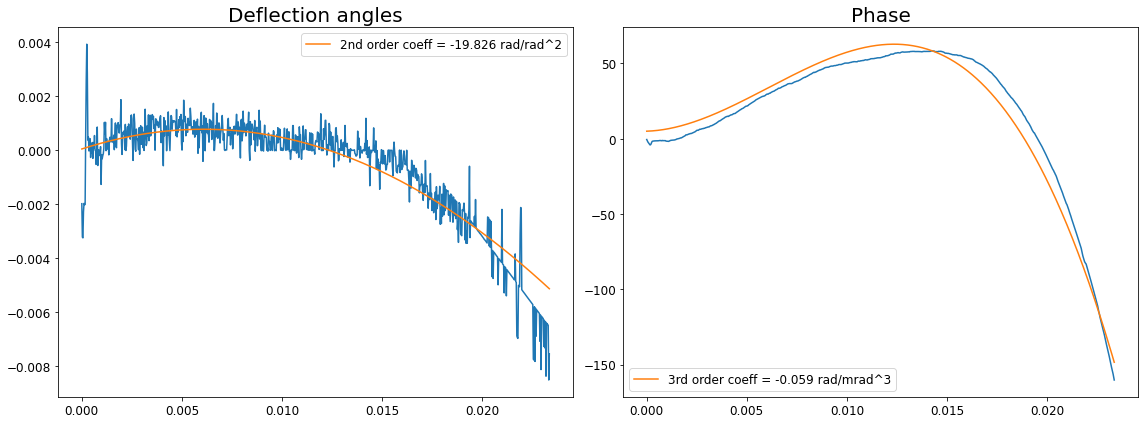

In [359]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_andrew_1727.pdf')

In [85]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=200, l_scale=7., n_iter=5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var)

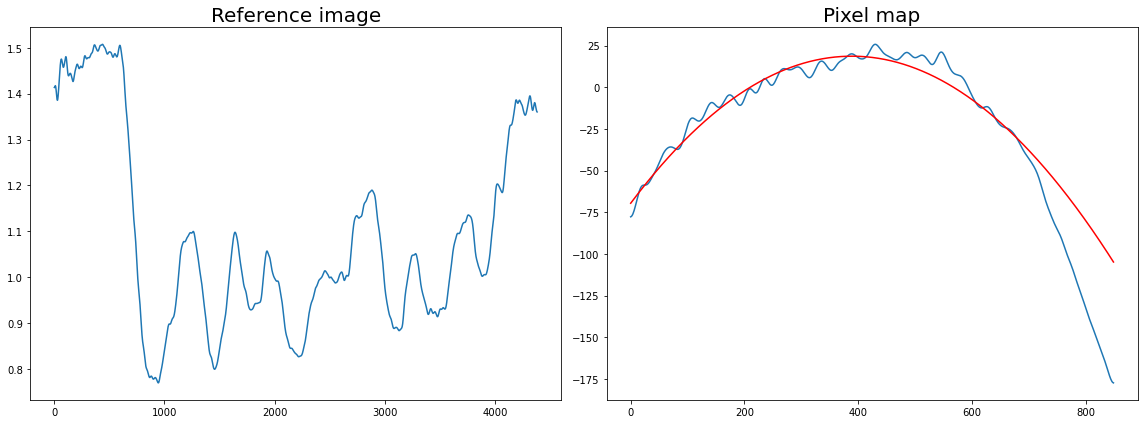

In [86]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_1896.pdf')

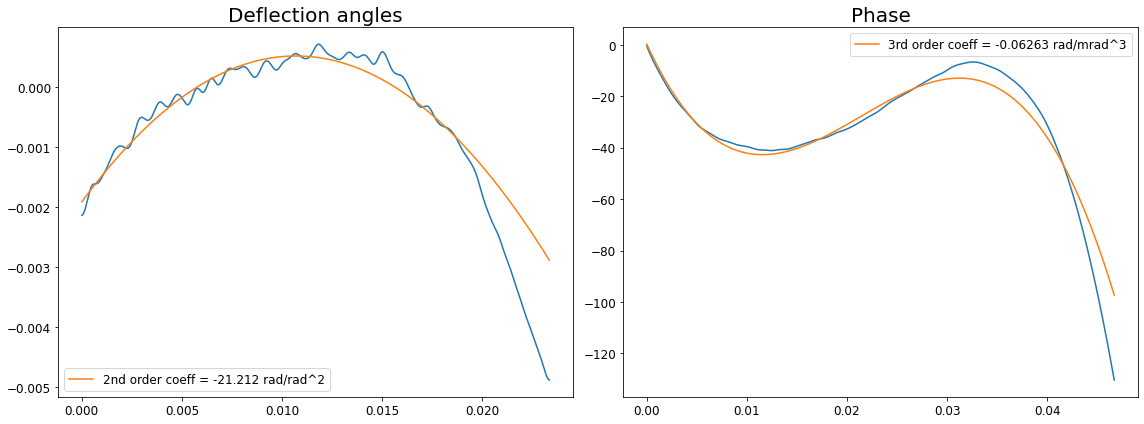

In [87]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(2 * phr_res['theta'], phr_res['phase'])
axes[1].plot(2 * phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_1896.pdf')